Ершов Артем, Москва

In [54]:
import pandas as pd
import numpy as np

import seaborn as sns
from IPython.display import IFrame

Для выраванивания будем использовать STAR, т.к. он умеет взаимодействовать с базой генов. Для количественной оценки воспользуемся featureCounts, по резултатам которого можно расчитать значение $\text{FPKM}$.

```bash
# build index
./STAR --runMode genomeGenerate --runThreadN 8 --genomeDir ./star-index --genomeFastaFiles ref.fa --sjdbGTFfile genes.gtf

# alignment
./STAR --runThreadN 8 --genomeDir ./star-index --readFilesIn SRR453566_1.fastq SRR453566_2.fastq

# counts
featureCounts -T 8 -a genes.gtf -o counts Aligned.out.sam

# mean frament length
# only check for fragments 600 bp or shorter (default upper limit for featureCounts)
cut -f 9 Aligned.out.sam  | grep -v '-' | awk '$1<601{ total += $1; count++ } END { print total/count }'
# result is ~216

# de-novo assembly
rnaspades.py -o rnaspades_assembly -1 SRR453566_1.fastq -2 SRR453566_2.fastq -t 8

# assembly evaluation
rnaQUAST.py -c rnaspades_assembly/transcripts.fasta -r ref.fa --gtf genes.gtf --disable_infer_genes --disable_infer_transcripts

```

In [19]:
df = pd.read_csv('HW7_data/counts', sep='\t', comment='#')
df.head()

,Geneid,Chr,Start,End,Strand,Length,Aligned.out.sam
0,YDL248W,IV,1802,2953,+,1152,624
1,YDL247W-A,IV,3762,3836,+,75,10
2,YDL247W,IV,5985,7814,+,1830,8
3,YDL246C,IV,8683,9756,-,1074,4
4,YDL245C,IV,11657,13360,-,1704,40


$\text{FPKM}_i = 10^9 \cdot\frac{X_i}{l_i \cdot N}$ , где $N$ - суммарное число выравнявшихся фрагментов; $X_i$ - число фрагментов, которые выравнялись на рассматриваемый ген; $l_i$ - длина этого гена 

Иногда говорят об эффективной длине гена $\tilde l = l - \mu_{FLD} + 1$, где $\mu_{FLD}$ - средняя длина фрагмента. Однако местами её опускают ([e.g.](http://assets.geneious.com/manual/8.0/GeneiousManualsu76.html)), а [здесь](https://www.biostars.org/p/390038/) пишут, что конкретно для анализа эскпрессии генов (а не различных изоформ гена) такая поправка не актуальна. По этой причине (а вовсе не потому, что иначе получаются отрицательные числа и я не уверен, что с ними делать) эффективную длину использовать не будем.

In [38]:
N = df['Aligned.out.sam'].sum()
df['FPKM'] = df['Aligned.out.sam'] / df['Length'] * (10**9 / N)

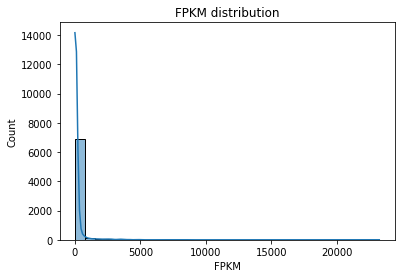

In [52]:
ax = sns.histplot(x=df['FPKM'], kde=True, bins=30);
ax.set_title('FPKM distribution');

Воспользуемся выделямыми в [Expression Atlas](https://www.ebi.ac.uk/gxa/FAQ.html) уровнями экспрессии: средней экспрессией обладают гены, для которых $\text{FPKM} > 11$ (эти же гены должны обладать достаточным покрытием).

In [78]:
df[df['FPKM'] > 11].shape[0]

5352

Сравним с результатами сборки:

(Гитхаб не отображает; pdf с результатами rnaQUAST находится по адресу ../HW7_data/short_report.pdf)

In [59]:
IFrame('HW7_data/short_report.pdf', width=600, height=800)

С собранными транскриптами выходит меньше генов (50% покрытых всего 4114 против 5352 генов со средним уровнем экспрессии, если смотреть по $\text{FPKM}$). Предположительно это происходит неоднородного покрытия и ошибок секвенирования, что приводит к появлению непокрытых участков генов.